In [10]:
%matplotlib inline
import deepdish as dd
import h5py
import numpy as np
from galaxy_analysis.analysis import Galaxy
from galaxy_analysis.plot.plot_styles import *
import matplotlib.pyplot as plt
from galaxy_analysis.utilities import utilities
from galaxy_analysis.utilities import convert_abundances

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import glob

import yt

fsize = 17
rc('text',usetex=False)
rc('font',size=fsize)


yr_s = 3.154E7

def is_alive(data, t):
    
    lifetime = data[('io','particle_model_lifetime')].convert_to_units('Myr')
    t0       = data['creation_time'].convert_to_units('Myr')
    alive    = np.array([True] * np.size(t0))
    
    not_born    = t <  t0
    dead        = t > (t0 + lifetime)
    alive[not_born] = False
    alive[dead]     = False
    
    return alive
    
    

In [2]:
def dlist_asarray(dict_list, key_list, as_list = False):
    
    res = [None]*len(dict_list)
    #print(len(dict_list))
    
    for i,d in enumerate(dict_list):
        res[i] = extract_nested_dict(d, key_list)
        
    if as_list:
        return res
    
    return np.array(res)
    
    
def extract_nested_dict(d, key_list):
    
    if isinstance(key_list, str):
        return d[key_list]
    elif len(key_list) == 1:
        return d[key_list[0]]
    
    return extract_nested_dict( d[key_list[0]], key_list[1:])

class DataContainer:
    
    def __init__(self, directory, file_list = None, self_contained = False,
                 name = None, data_file_name = "*_galaxy_data.h5"):
        
        self.directory = directory
        
        self.self_contained = self_contained # sets if the "file list" is a list
                                             # files to be loaded (False) or 
                                             # a list of data dump names (True)
                                             # contained within the data_file_name
        
        self.file_list      = file_list
        self.data_file_name = data_file_name

        self._data = {} # stores data
        
        if (self.file_list is None):
            
            if not self.self_contained:
                self.file_list = np.sort(glob.glob(directory + '/' + self.data_file_name))
            else:
                raise NotImplementedError 
      
    
        self.known_paths = {'SFR'  : '/time_data/SFR',
                            'time' : '/meta_data/Time',
                            'meta_data' : '/meta_data',
                           }
        
        if name is None:
            self.name = directory
            
        # do some prep
        self.load_field(self.known_paths['time'],label='time',
                        reload=True, to_array=True)
        
        self.load_field(self.known_paths['meta_data'], label='meta_data',
                        reload=True, to_array=False)
                
        # pre-load the easy things
        for k in self._data['meta_data'][0].keys():
            self._data[k] = dlist_asarray( self._data['meta_data'], [k])
    
        return
        
    def data(self, label):
        
        if label in self.loaded_fields():
            return self._data[label]
        
        if label in self.known_paths:
            path = self.known_paths[label]
        
        self.load_field(path, label=label)
        
        return self._data[label]
            
    
    def load_single(self, path, filename = None, index = None):
        
        if (filename is None) and (index is None):
            print("Must provide either name of file or index in file_list")
            raise ValueError
            
        if (filename is None):
            filename = self.file_list[index]
            
        if path in self.known_paths.keys(): # assume path = label if true
            path = self.known_paths[path]
                
        
        return dd.io.load(filename, path)
        
        
    def load_field(self, path, label = None, reload = False,
                               to_array    = True):
        """
        Grab data from file given dictionary path. 
        
        path   :  str
            string or list of strings to pass to deepdish
            to selectively load the desired field. 
        label  : str, optional
            optional alias to be used in place of path
            in self.data dictionary. Default: none (set to path)
        reload  : bool, optional
            By default, just returns data in self.data if 
            label exists already. Otherwise reloads and overwrites.
            Default : False
        to_array: bool, optional
            By default, if retrieved data are just single scalars
            it is stored as a numpy array. Otherwise it is kept 
            as a list. Set this to override default behavior
            and keep as list
        """
        
        if (label is None):
            label = path
                          
        if (path is None):
            path = self.known_paths[label]
            
        if not reload:
            if label in self._data.keys():
                return self._data[label]
                
        # else - load
        self._data[label] = [0.0]*np.size(self.file_list)
        fail_count = 0
        for i,filename in enumerate(self.file_list):
                          
            try:
                self._data[label][i] = dd.io.load(filename,path)
            except:
                self._data[label][i] = None
                fail_count += 1
                          
            if fail_count > 10:
                print("Failed more than %i times loading with path %s and label %s"%(fail_count, path, label))
                raise RuntimeError
        
        if to_array:
            self._data[label] = np.array(self._data[label])
                          
        return self._data[label]
            
    def loaded_fields(self):
        return self._data.keys()
        
        
        

In [6]:
fid_dir  = '/home/aemerick/work/enzo_runs/leo_p/fiducial/sn_H2atten_H2sh'
work_dir = '/home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2'

filepaths = {'sn_only' : work_dir + '/sn_only',
             'fiducial' : fid_dir + '/../3pc_H2', 'fiducial-1.8pc' : fid_dir}
             

labels    = {'sn_only' : 'SN-only',
             'ion_no-otrad-sn' : 'Ionization only',
             'otrad_ion-no-sn' : 'Radiation only',
             'otrad_no-ion-sn' : 'PE+LW only',
             'shortrad'        : 'shortrad',
             'shortrad_72pc'   : 'shortrad-72pc',
             'sn_ion-no-otrad' : 'SN + Ion',
             'sn_otrad_no-ion' : 'SN + PE+LW',
             'sn_otrad_ion_RPx2' : 'RPx2',
             'sn_otrad_ion_RPx5' : 'RPx5',
             'sn_otrad_ion_noRP'     : 'RPx0',
             'fiducial-1.8pc' : 'Fiducial-1.8pc',
             'fiducial'      : 'Fiducial'}


base_comparison = ['fiducial', 'sn_ion-no-otrad', 'sn_otrad_no-ion', 'sn_only', 
                   'otrad_ion-no-sn', 'ion_no-otrad-sn', 'otrad_no-ion-sn', 'sn_otrad_ion_noRP', 'shortrad']


colors = {}
for i,k in enumerate(labels.keys()):
    colors[k] = "C%0i"%(i)
colors['fiducial'] = 'black'
#
#colors['sn_otrad_ion_noRP'] = 'black'

lstyles = {}
for i,k in enumerate(labels.keys()):
    lstyles[k] = '-'
lstyles['sn_otrad_ion_noRP'] = ':'


if True:
    # try some color scheme
    colors['fiducial'] = 'black';        lstyles['fiducial'] = '-'
    colors['sn_ion-no-otrad'] = 'black'; lstyles['sn_ion-no-otrad'] = '--'
    colors['sn_otrad_no-ion'] = 'black'; lstyles['sn_otrad_no-ion'] = '-.'
    colors['sn_only']  = 'black';        lstyles['sn_only'] = ':'
    
    colors['otrad_ion-no-sn'] = 'C3';  lstyles['otrad_ion-no-sn'] = '-'
    colors['otrad_no-ion-sn'] = 'C3';  lstyles['otrad_no-ion-sn'] = '--'
    colors['ion_no-otrad-sn'] = 'C3';  lstyles['ion_no-otrad-sn'] = ':' 
    
    colors['shortrad'] = 'C0'
    colors['sn_otrad_ion_noRP'] = 'C1'; lstyles['sn_otrad_ion_noRP'] = '-'
    colors['sn_otrad_ion_RPx2'] = 'C1'; lstyles['sn_otrad_ion_RPx2'] = '--'
    colors['sn_otrad_ion_RPx5'] = 'C1'; lstyles['sn_otrad_ion_RPx5'] = ':'

    


for l in labels:
    if not (l in filepaths.keys()):
        filepaths[l] = work_dir + '/' + l
        
        
# try and load all galaxies

all_galaxies = {}
for l in base_comparison:
    ds_avail        = np.sort(glob.glob(filepaths[l] + "/DD????/DD????"))
    
    if len(ds_avail) > 0:
        dsname = ds_avail[-1].split("/")[-1]
        
        try:
            print(l, dsname)
            all_galaxies[l] = Galaxy(dsname, wdir = filepaths[l])
            
        except:
            print("failing on ",l,dsname)
            all_galaxies[l] = None
    else:
        print("no galaxy data dumps available for run ", l)
        all_galaxies[l] = None
        
h5data_dict    = {}
data_list_dict = {}
infile_dict    = {}

for run in filepaths.keys():
#    infile_dict[run] = '/home/aemerick/work/enzo_runs/mixing_experiment/' + run + '/' + run + '_gas_abundances.h5'
    infile_dict[run] = filepaths[run] + '/abundances/gas_abundances.h5' 
    
    h5data_dict[run] = h5py.File(infile_dict[run],'r')
    data_list_dict[run] = np.sort([x for x in h5data_dict[run].keys() if 'DD' in x])
    h5data_dict[run].close()

fiducial DD0729


Parsing Hierarchy : 100%|██████████| 1006/1006 [00:00<00:00, 9676.02it/s]


sn_ion-no-otrad DD0847


Parsing Hierarchy : 100%|██████████| 1049/1049 [00:00<00:00, 13016.39it/s]


sn_otrad_no-ion DD0522


Parsing Hierarchy : 100%|██████████| 1752/1752 [00:00<00:00, 13665.84it/s]


sn_only DD0201


Parsing Hierarchy : 100%|██████████| 3556/3556 [00:00<00:00, 9043.19it/s] 


otrad_ion-no-sn DD0937


Parsing Hierarchy : 100%|██████████| 678/678 [00:00<00:00, 2760.42it/s]


ion_no-otrad-sn DD1000


Parsing Hierarchy : 100%|██████████| 883/883 [00:00<00:00, 11706.75it/s]


otrad_no-ion-sn DD0628


Parsing Hierarchy : 100%|██████████| 848/848 [00:00<00:00, 2564.69it/s]


sn_otrad_ion_noRP DD0854


Parsing Hierarchy : 100%|██████████| 1030/1030 [00:00<00:00, 7735.08it/s]


shortrad DD0369


Parsing Hierarchy : 100%|██████████| 430/430 [00:00<00:00, 10892.32it/s]


In [4]:
data_list = None
infile     = '/home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2/sn_only/abundances/gas_abundances.h5'
# h5data    = h5py.File('/home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2/sn_only/abundances/gas_abundances.h5', 'r')
zbins     = dd.io.load(infile,'/DD0150/CNM/mass_fraction/bins')

infile = None

def bytes_to_string(obj):
    """
    Seems some of the string data I've written to file in python 2.x code
    is being read in as bytes now. But sadly I want them to be strings
    May need to do this a lot.....
    """
    if (not isinstance(obj, list)) and (not isinstance(obj,np.ndarray)):
        if isinstance(obj, bytes):
            return obj.decode()
    
    # could put a check in to see if ANY are even bytes in the 
    # first place and just return the original obj.... but lazy...
    ret = [x.decode() if isinstance(x,bytes) else x for x in obj]
    
    if isinstance(obj, np.ndarray):
        return np.array(ret)
    else:
        return ret

def get_mass_fraction(zdex=None, mf = None, data_names = data_list, fname = infile,
                          bins = zbins, elements = None,
                          norm_stat = 'median', phase = 'CNM'):
    
    
    if elements is None:
        elements = dd.io.load(fname, '/metal_species')
    elif isinstance(elements, str):
        elements = [elements]
    
    result = {}
    for e in elements:
        result[e] = np.zeros(np.size(data_names))
        
    result['time'] = np.zeros(np.size(data_names))
    
    log_z  = np.log10( 0.5 * (bins[1:] + bins[:-1]))
    
    for i,d in enumerate(data_names):
        #
        # load mass fraction
        # 
        dname = str(d)
        for e in elements:
            mass_data  = dd.io.load(fname, '/' + dname + '/' + phase + '/mass_fraction/' + e + '_Fraction')
        
            # np.interp(mf, np.cumsum(SN['hist']), log_z - SN['median'])
        
            if (norm_stat is None) or (norm_stat == ""):
                norm  = np.zeros(np.size(log_z))
            else:
                norm   = np.log10(mass_data[norm_stat])
        
            # find the 1 dex limit
            if (not (zdex is None)):
                result[e][i]= 1.0 - np.interp(zdex, log_z - SN_norm, np.cumsum(mass_data['hist']))
            
            else:
                result[e][i]  = np.interp(1.0-mf, np.cumsum( mass_data['hist']), log_z -  norm)
            
        result['time'][i] = dd.io.load(fname, '/'+dname+'/general/Time')
        
        # slightly better will be to just track the time evolution of 0.10 and 0.9
        # mass fractions (how far from mediam)
        
    result['time'] = result['time'] - result['time'][0]
    
    return result




def get_stat(statname, data_names = data_list, fname = infile,
             bins = zbins, elements = None, logval = False, average_all= False, average_type = None, phase = 'CNM'):
    
    
    if elements is None:
        elements = dd.io.load(fname, '/metal_species')
        
    elif isinstance(elements, str):
        elements = [elements]

    elements = bytes_to_string(elements)        
  
    result = {}
    for e in elements:
        
        if statname != 'hist':
            result[e] = np.zeros(np.size(data_names))
        else:
            result[e] = [None]*np.size(data_names)    
            
    if statname != 'hist':
        result['combined'] = np.zeros(np.size(data_names))
    else:
        result['combined'] = [None]*np.size(data_names)   
        
        
    result['time'] = np.zeros(np.size(data_names))
    
    log_z  = np.log10( 0.5 * (bins[1:] + bins[:-1]))
    
    
    for i,d in enumerate(data_names):
        #
        # load mass fraction
        # 
        dname = str(d)
        for e in elements:
            
            #try:
            #e = str(e)
           # print( dname, phase, e)
            mass_data  = dd.io.load(fname, '/' + dname + '/' + phase + '/mass_fraction/' + e + '_Fraction')
            #except:
            #    print("Failing for " + dname, e)
            #    continue
        
            # np.interp(mf, np.cumsum(SN['hist']), log_z - SN['median'])
        
            # find the 1 dex limit
            
            result[e][i] = mass_data[statname]
            
        try:
            mass_data = dd.io.load(fname, '/' + dname + '/' + phase + '/mass_fraction/combined')
            result['combined'][i] = mass_data[statname]
        except:
            if statname != 'hist':
                result['combined'][i] = 9999999
            else:
                result['combined'][i] = np.ones(np.size(zbins))*9999999
        

        
        result['time'][i] = dd.io.load(fname, '/'+dname+'/general/Time')
        
        # slightly better will be to just track the time evolution of 0.10 and 0.9
        # mass fractions (how far from mediam)

    if logval:
        for e in elements:
            result[e] = np.log10(result[e])
        result['combined'] = np.log10(result['combined'])
        
    result['time'] = result['time'] - result['time'][0]
    
    if average_all:
        if statname != 'hist':
            result['average'] = np.zeros(np.size(result['time']))
        else:
            
            result['average'] = np.zeros(np.shape(result[e]))
           
        count = 0
        for k in result.keys():
            
            if average_type is None:
                if k == 'time' or k =='average' or k =='combined' or np.isnan(result[k][0]):
                    continue
            else:
                if not (k in abundances_to_average[average_type]):
                    continue
                if k == 'combined':
                    continue
                    
            if statname == 'hist':
                #temp = result[k]*1.0
                #temp[ np.isinf(temp) ] = 0.0
                
                temp = 10.0**(result[k])            
                #
                # some of the mass might be below the -20 bin threshold in the histogram...
                # I need to account for this in averaging in order for the averaged
                # histogram to have the same CDF / PDF properties
                #
                #tempsum = np.cumsum(temp,axis=1)
                #temp = (temp.transpose() + (1.0 - tempsum[:,-1])).transpose()

                temp[:,0] = temp[:,0] + (1.0 - np.cumsum(temp,axis=1)[:,-1])
                result['average'] = result['average'] + temp  
            
            #elif (statname == 'mean' or statname == 'median'):
            #    result['average'] = result['average'] + 10.0**(result[k])
                # take log of average, not average of log!!!
            else:
                
                result['average'] = result['average'] + result[k]
            count = count + 1
            
        result['average'] = result['average']/(1.0 * count)
        if statname == 'hist':# or statname == 'median' or statname == 'mean':
        #    result['average'][result['average']==0.0] = -np.inf
            result['average'] = np.log10(result['average'])
            result['average'][ np.isnan(result['average']) ] = -np.inf # check this
                
    
    return result

def list_stats(data_name, fname = infile):
    
    if not (isinstance(data_name,str)):
        if isinstance(data_name[0],str):
            dname = data_name[0]
        else:
            raise ValueError
    else:
        dname = data_name
        
    return (dd.io.load(fname, '/' + str(dname) +'/CNM/mass_fraction/O_Fraction')).keys()    
    
def _get_plot_values(xall_data, phase, run, stat, species = 'average'):
    
    
    
    if stat in xall_data[run][phase].keys():
        y = xall_data[run][phase][stat][species]
    elif stat == 'mean-median':
        y = xall_data[run][phase]['mean'][species] - xall_data[run][phase]['median'][species]
    elif stat == 'max-min':
        y = xall_data[run][phase]['max'][species] - xall_data[run][phase]['min'][species]
    elif stat == 'IQR':
        y = xall_data[run][phase]['Q3'][species] - xall_data[run][phase]['Q1'][species]
    elif stat == 'IDR':
        y = xall_data[run][phase]['decile_9'][species] - xall_data[run][phase]['decile_1'][species]
    else:
        raise ValueError
    
    time = xall_data[run][phase]['mean']['time']
    
    return time, y






In [5]:
all_data = {}

phases   = ['CNM']

for run in base_comparison:

    all_data[run] = {}
    
    for phase in phases:
    
        all_data[run][phase] = {}
        
        for stat in ['mean','median','hist','Q1','Q3']:
            all_data[run][phase][stat] = get_stat(stat,logval=True,average_all=False,
                                                  data_names = data_list_dict[run],
                                                  elements = ['Ba','Fe','O','Mg','N'],
                                                  fname = infile_dict[run], phase = phase)
            
       # need to re-measure median:
        #
        

        


/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:149: RuntimeWarning: divide by zero encountered in log10


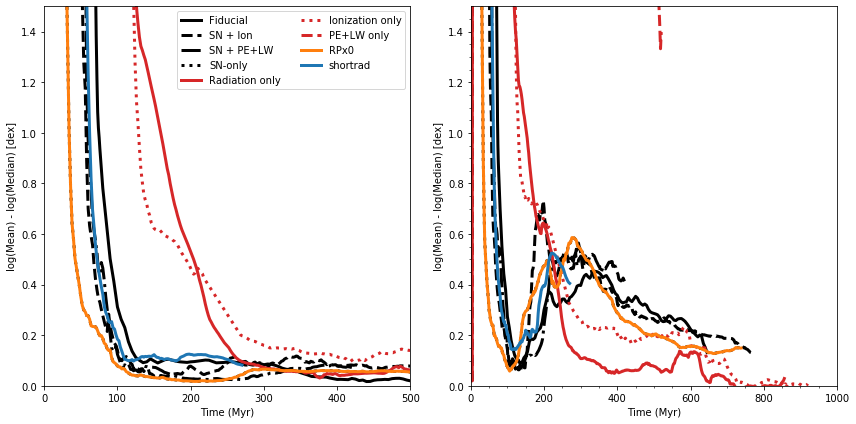

In [13]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

plot_runs = base_comparison
    
for run in plot_runs:
    x,y = _get_plot_values(all_data, 'CNM', run, 'mean-median', 'O')
    ax[0].plot(x-x[0], y, color = colors[run], lw = 3, ls = lstyles[run], label = labels[run])
for run in plot_runs:
    x,y = _get_plot_values(all_data, 'CNM', run, 'mean-median', 'Ba')
    ax[1].plot(x-x[0], y, color = colors[run], lw = 3, ls = lstyles[run], label = labels[run])

for a in ax:
    a.set_xlim(0,1000.0)
    a.set_ylim(0,1.5)
    a.set_ylabel(r'log(Mean) - log(Median) [dex]')
    a.set_xlabel(r'Time (Myr)')

ax[0].legend(ncol=2)
plt.minorticks_on()
plt.tight_layout()

ax[0].set_xlim(0,500)
#ax[0].annotate("ISM", xy = (10,1), xycoords = 'data')
#ax.annotate("CNM-only", xy = (10,1), xycoords = 'data')


fig.savefig("physics_comparison_mean-median.png")

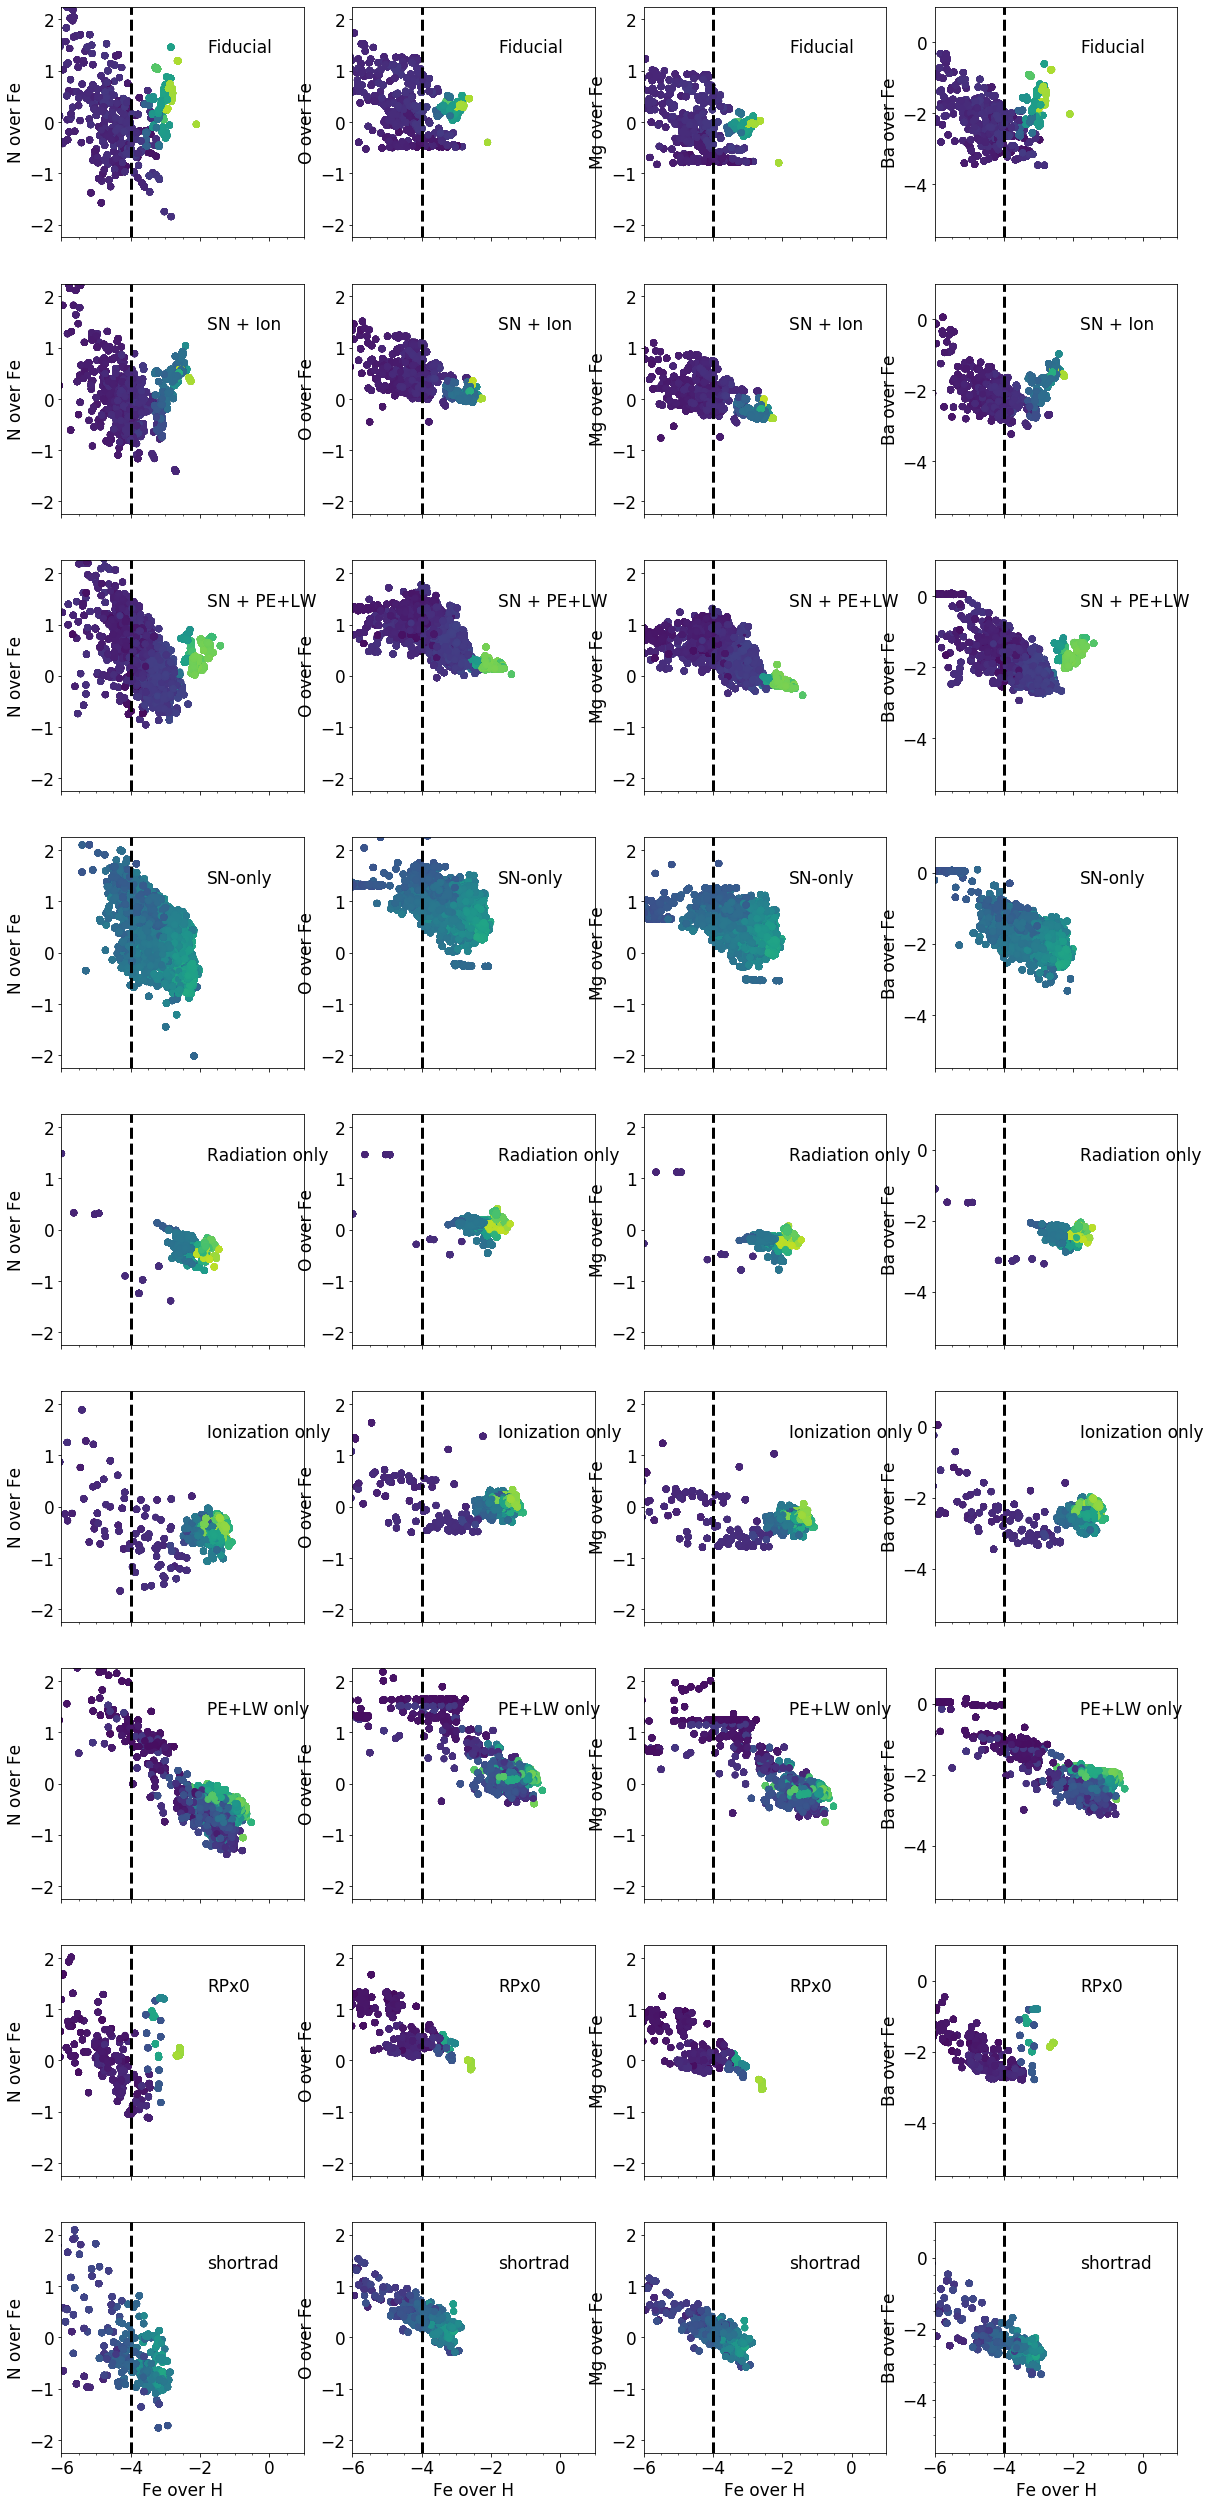

In [26]:
t = 1200.0 * yt.units.Myr

elements = ['N','O','Mg','Ba']

plot_runs = base_comparison

nrow = len(plot_runs)
ncol = 4
fig,ax = plt.subplots(nrow, ncol,sharex=True)
fig.set_size_inches(ncol*5,nrow*5)

axi = 0
axj = 0


denom_element = 'Fe'
#xdata = xdata - np.min(xdata)

e1 = 'Fe'
e2 = 'H'
#xdata = convert_abundances.renormalize(xdata, e1,e2)


for run in plot_runs:
    
    gal = all_galaxies[run]
    
    select = is_alive(gal.df, t)
    
    
    cdata = gal.df['creation_time'].convert_to_units('Myr')
    cdata = (cdata - np.min(cdata)) / np.max(cdata) *1200 # set same scaling for all ?
    
    
    xdata = gal.df[('io','particle_' + e1 + '_over_' + e2)]

    bins = np.arange(-30,0, 0.1)
    for e in elements:
        index = (axi,axj)
        if e == denom_element:
            continue
        
        ydata = gal.df[('io','particle_' + e + '_over_' + denom_element)]
    #ydata = convert_abundances.renormalize(ydata, e, denom_element)
    
        cax = ax[index].scatter(xdata[select], ydata[select], c = cdata[select])
        cax.set_clim(0.0,1200.0)

    #ax[index].set_xlim(-20,0)
    #ax[index].set_ylim(0,1)
    #ax[index].semilogy()
        ax[index].set_ylabel(e + ' over ' + denom_element)
        ax[index].set_xlim(-6, 1)
        

        #ax[index].set_ylim(np.median(ydata[select]) - 2, np.median(ydata[select]) + 2)
        if e == 'Ba':
            ax[index].set_ylim(-5.5,1)
        else:
            ax[index].set_ylim(-2.25,2.25)
        
        ax[index].plot([-4,-4],ax[index].get_ylim(), lw = 3, ls = '--', color = 'black')
    
        xy = (0.6,0.8)
        ax[index].annotate(labels[run], xy,xy, xycoords='axes fraction')
    
        axj = axj + 1
        if axj >= ncol:
            axj = 0
            axi = axi + 1
            
            
        plt.minorticks_on()
        
for i in np.arange(ncol):
    ax[(nrow-1,i)].set_xlabel(e1 + ' over ' + e2)

    
fig.savefig("physics_comparison_stellar_abundances.png")